# Import

In [1]:
from CNN import CNN
from Utils import *
import os
from torch.utils.data import DataLoader

PATH_PROJECT_ROBIN = "/home/robin/Bureau/ETUDES/M2/S2/TAP/"
PATH_PROJECT_QUENTIN = "..."
PATH_PROJECT_PERSONNE = PATH_PROJECT_ROBIN
PATH_RAW_DATASET = "Projet-Traitement-Automatique-de-la-Parole/Dataset/"
GLOBAL_PATH_DATASET = os.path.join(PATH_PROJECT_PERSONNE, PATH_RAW_DATASET)
GLOBAL_PATH_RAW_DATASET = os.path.join(GLOBAL_PATH_DATASET, "speech_commands_v0.02/")
GLOBAL_PATH_BASIC_DATASET = os.path.join(GLOBAL_PATH_DATASET, "Dataset_basique/")
filename = os.path.join(GLOBAL_PATH_DATASET, "dataset_basique.pkl")

# Get dataset

In [2]:
with open(filename, "rb") as f:
    data = pickle.load(f)

In [3]:
x_train, y_train, metadata_train = data["train"]["signals"][:200], data["train"]["labels"][:200], data["train"]["metadata"][:200]
x_val, y_val, metadata_val = data["val"]["signals"][:200], data["val"]["labels"][:200], data["val"]["metadata"][:200]
x_test, y_test, metadata_test = data["test"]["signals"][:200], data["test"]["labels"][:200], data["test"]["metadata"][:200]

train_dataset = SpeechCommandDataset(x_train, y_train, metadata_train, transform_type="MFCC")
val_dataset = SpeechCommandDataset(x_val, y_val, metadata_val, transform_type="MFCC")
test_dataset = SpeechCommandDataset(x_test, y_test, metadata_test, transform_type="MFCC")

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

# Train model

In [4]:
model = CNN(1,6)
model, train_loss, val_acc, val_loss = train(model,train_loader,val_loader, nb_steps=500)

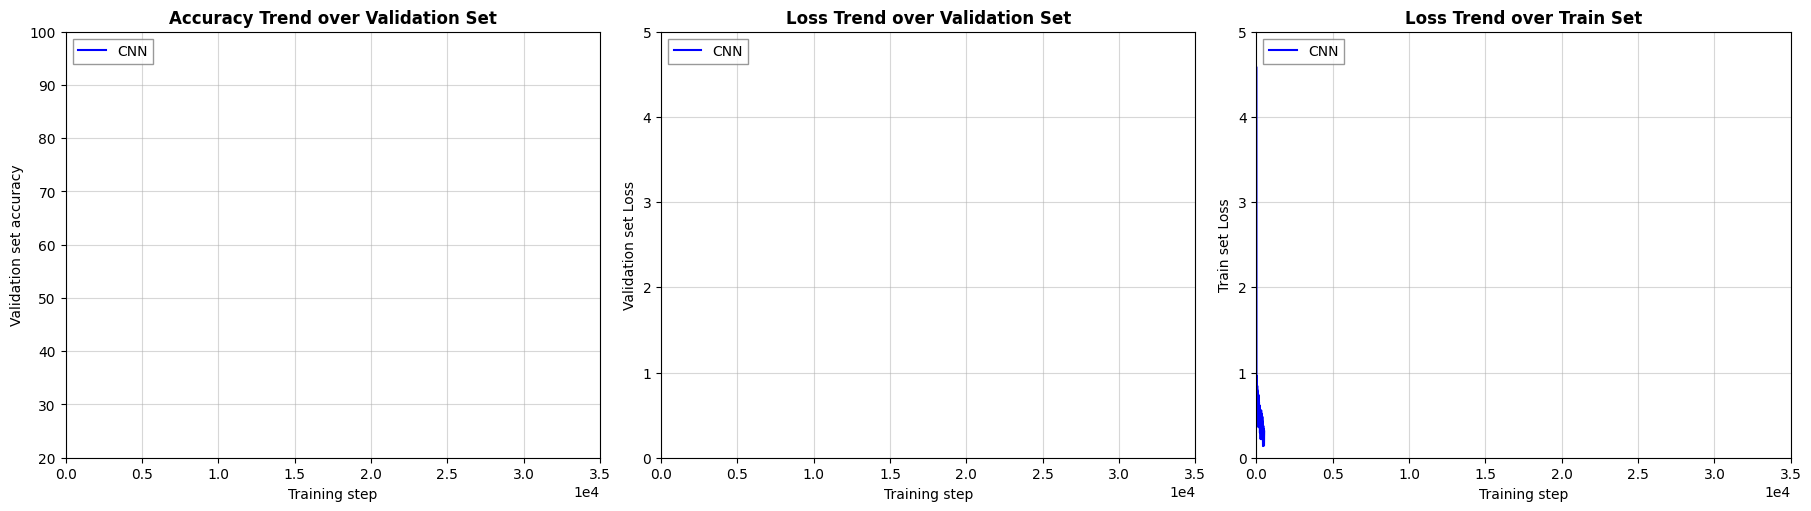

In [5]:
plot_all_data([([(val_acc,"CNN","blue")],"Accuracy Trend over Validation Set","Training step","Validation set accuracy",400,20,100),
               ([(val_loss,"CNN","blue")],"Loss Trend over Validation Set","Training step","Validation set Loss",400,0,5),
               ([(train_loss,"CNN","blue")],"Loss Trend over Train Set","Training step","Train set Loss",1,0,5)])

# Test and plot model

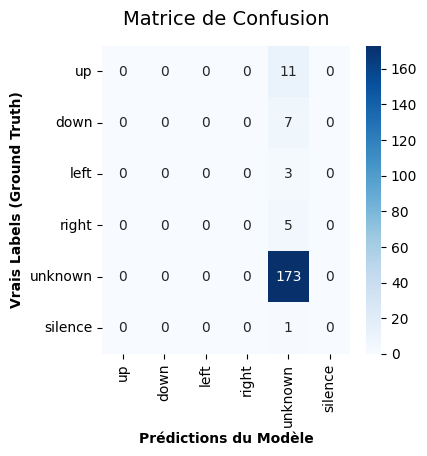

In [6]:
accuracy, all_preds, all_labels, all_probs, loss = evaluate(model, test_loader)
cm = plot_custom_confusion_matrix(all_preds, all_labels, class_names=data['mapping'])

# Test nombre de paramètres

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_size,out_channels=64,kernel_size=13,stride=5,padding=1)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(5,8),stride=2,padding=1)

        self.lin = nn.Linear(64 * 10 * 4, 32)
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, output_size)

        self.dropOut = nn.Dropout(p = 0.5)
        self.maxPool = nn.MaxPool2d((1, 3),stride=(1,1),padding=(0,1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropOut(self.relu(self.conv1(x)))
        x = self.maxPool(x)
        x = self.dropOut(self.relu(self.conv2(x)))
        x = self.relu(self.lin(x.view(x.size(0), -1)))
        x = self.dropOut(self.relu(self.fc1(x)))
        x = self.relu(self.fc2(x))
        return x

model_summary(CNN(1,6))

Couche(conv1.weight) : 10816 (Paramètres)
Couche(conv1.bias) : 64 (Paramètres)
Couche(conv2.weight) : 163840 (Paramètres)
Couche(conv2.bias) : 64 (Paramètres)
Couche(lin.weight) : 81920 (Paramètres)
Couche(lin.bias) : 32 (Paramètres)
Couche(fc1.weight) : 4096 (Paramètres)
Couche(fc1.bias) : 128 (Paramètres)
Couche(fc2.weight) : 768 (Paramètres)
Couche(fc2.bias) : 6 (Paramètres)
Total : 261734 (Paramètres)
